In [ ]:
# # uncomment to install needed packages
# !pip install matplotlib
# !pip install wheel
# !pip install pipwin

# !pipwin install numpy
# !pipwin install pandas
# !pipwin install shapely
# !pipwin install gdal
# !pipwin install fiona
# !pipwin install pyproj
# !pipwin install six
# !pipwin install rtree
# !pipwin install geopandas
# !pip install xlrd
# !pip install descartes

In [2]:
import requests
import json
import matplotlib.pyplot as plt
import geopandas as gpd
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
states = ["AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
shp = gpd.read_file("s_11au16/s_11au16.shp")
state_pop = pd.read_excel("pop_est.xlsx")

In [3]:
state_pop["NAME"] = state_pop["NAME"].str.lstrip(".")

In [4]:
state_pop = state_pop[["NAME",2019]]

In [5]:
state_pop.columns = ['NAME',"2019"]

In [6]:
url = "https://covidtracking.com/api/v1/states/daily.json"
req = requests.get(url)
result = json.loads(req.text) 


In [7]:
data = {}
for x in result:
    if x["state"] in data:
        data[x["state"]][x["date"]] = x
    else:
        data[x["state"]] = {x["date"]:x}
data2 = {}
for x in result:
    if x["state"] in data2:
        data2[x["state"]].append(x)
    else:
        data2[x["state"]] = [x]

In [8]:
dfs = {}
results = []
for state in data2:
    if state in states:
        dfs[state] = pd.DataFrame(data=data2[state])
        dfs[state] = dfs[state].sort_values(by="date")
        dfs[state]["totalTestResultsIncreaseRolling7"]= dfs[state]["totalTestResultsIncrease"].rolling(7,min_periods=1).sum()
        dfs[state]["positiveIncreaseRolling7"]= dfs[state]["positiveIncrease"].rolling(7,min_periods=1).sum()
        dfs[state]["rollingPositive7"] = dfs[state]["positiveIncreaseRolling7"]/dfs[state]["totalTestResultsIncreaseRolling7"]
        dfs[state]["deathIncreaseRolling7"] = dfs[state]["deathIncrease"].rolling(7,min_periods=1).sum()
        dfs[state]["hospitalizedIncreaseRolling7"] = dfs[state]["hospitalizedIncrease"].rolling(7,min_periods=1).sum()
        dfs[state]
        results.append(dfs[state][dfs[state]["date"] == dfs[state]["date"].max()])
#                 results.append(dfs[state][dfs[state]["date"] == dfs[state]["date"].max()])

In [9]:
res = pd.concat(results)
res["rollingPositive7"] = res["rollingPositive7"]*100

In [10]:
geo = shp.set_index("STATE").join(res[["state","rollingPositive7","deathIncreaseRolling7","hospitalizedIncreaseRolling7","positiveIncreaseRolling7"]].set_index("state"), how="left")
geo = geo.set_index("NAME").join(state_pop.set_index("NAME"),how="left")
geo["rollingPositive7"] = geo["rollingPositive7"].fillna(0)
geo["deathIncreaseRolling7"] = geo["deathIncreaseRolling7"].fillna(0)
geo["hospitalizedIncreaseRolling7"] = geo["hospitalizedIncreaseRolling7"].fillna(0)
geo = geo[((geo["LON"] < -55) & (geo["LON"] > -150))]
geo = geo[geo["LAT"] > 20]
geo["death7"] = (geo["deathIncreaseRolling7"]/geo["2019"]) * 1000000
geo["posByPop"] = (geo["positiveIncreaseRolling7"]/geo["2019"]) * 1000000

In [11]:
import matplotlib.colors as mcolors
cmax = geo["rollingPositive7"].max()
cmin = 0
cmid = 5
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
c_array = [c('#006400'), c('#ffff00'), cmid/cmax]
mono = ["#ff0000","#e60000","#cc0000","#b30000"]

# mono = ["#ff3333","#ff1a1a","#ff0000","#e60000","#cc0000","#b30000"]
# mono = ["#ff8000","#ff8800","#ff0000","#cc0000","#b30000"]
num = math.ceil(cmax/cmid)
if num < len(mono):
    mono = mono[len(mono)-num+1:]
c_array.append(c('#ffff00'))
c_array.append(c(mono[0]))
c_array.append(cmid*2/cmax)
for i in range(len(mono)-2):
    c_array.append(c(mono[i]))
    c_array.append(c(mono[i+1]))
    c_array.append(cmid*(i+3)/cmax)
c_array.append(c(mono[len(mono)-2]))
c_array.append(c(mono[len(mono)-1]))
c_array
rvb = make_colormap(c_array)
# rvb = make_colormap(
#     [c('#00008b'), c('#ffffff'), cmid/cmax,  
#      c('#ffffff'), c('#8b0000')])

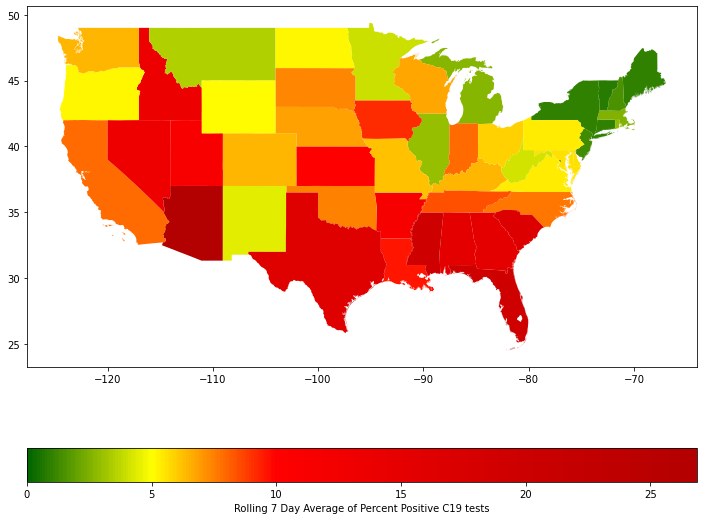

In [12]:
geo.plot(column="rollingPositive7", 
          figsize=(12, 10), 
          cmap=rvb, 
          vmin=0, 
          vmax=geo["rollingPositive7"].max(), 
          legend=True,
          legend_kwds={'label': "Rolling 7 Day Average of Percent Positive C19 tests",
                       'orientation': "horizontal"})

In [13]:
cmax

26.859084270019686

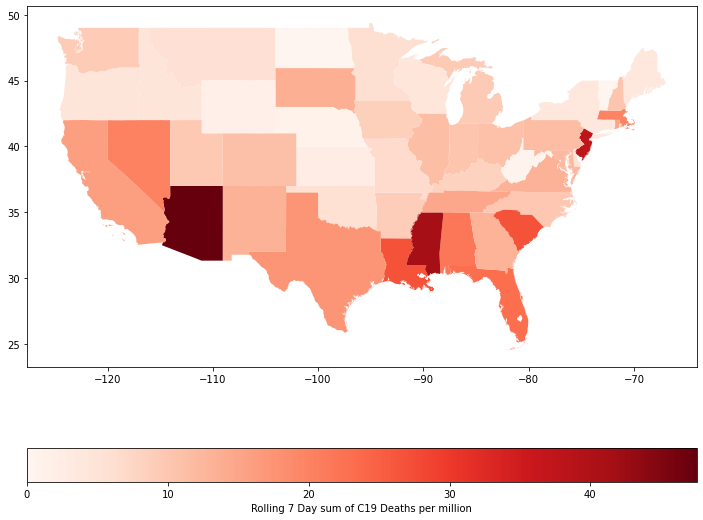

In [14]:
geo.plot(column="death7", 
          figsize=(12, 10), 
          cmap="Reds", 
          vmin=0, 
          vmax=geo["death7"].max(), 
          legend=True,
          legend_kwds={'label': "Rolling 7 Day sum of C19 Deaths per million",
                       'orientation': "horizontal"})

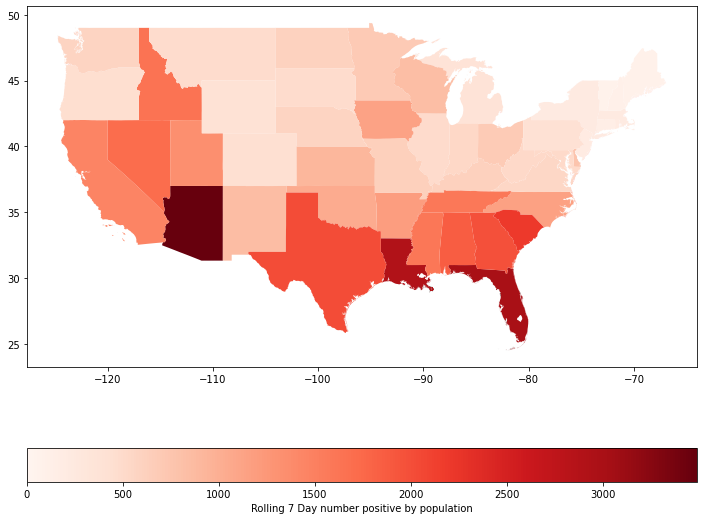

In [15]:
geo.plot(column="posByPop", 
          figsize=(12, 10), 
          cmap="Reds", 
          vmin=0, 
          vmax=geo["posByPop"].max(), 
          legend=True,
          legend_kwds={'label': "Rolling 7 Day number positive by population",
                       'orientation': "horizontal"})

In [16]:
geo["death7"] = (geo["deathIncreaseRolling7"]/geo["2019"]) * 1000000
geo

,FIPS,LON,LAT,geometry,rollingPositive7,deathIncreaseRolling7,hospitalizedIncreaseRolling7,positiveIncreaseRolling7,2019,death7,posByPop
NAME,,,,,,,,,,,
Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",15.158847,107.0,3839.0,9085.0,4903185.0,21.822550,1852.877262
Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",26.859084,346.0,682.0,25377.0,7278717.0,47.535850,3486.466090
Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",11.685525,27.0,244.0,3594.0,3017804.0,8.946903,1190.932214
California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",7.970371,632.0,0.0,57599.0,39512223.0,15.995050,1457.751441
Colorado,08,-105.54783,38.99855,"POLYGON ((-106.87560 41.00301, -106.85850 41.0...",6.412846,65.0,327.0,2572.0,5758736.0,11.287199,446.625787
Connecticut,09,-72.72623,41.62196,"MULTIPOLYGON (((-73.62247 40.98430, -73.62209 ...",0.973693,13.0,141.0,570.0,3565287.0,3.646270,159.874927
Delaware,10,-75.50592,38.99559,"MULTIPOLYGON (((-75.22731 38.58854, -75.22744 ...",5.565489,5.0,0.0,747.0,973764.0,5.134714,767.126326
District of Columbia,11,-77.01464,38.90932,"MULTIPOLYGON (((-77.03097 38.80826, -77.03110 ...",0.000000,0.0,0.0,NaN,705749.0,0.000000,NaN
Florida,12,-82.50934,28.67402,"MULTIPOLYGON (((-81.96339 24.52110, -81.96374 ...",19.604199,498.0,2301.0,64459.0,21477737.0,23.186800,3001.200732
